# 사전 설정

In [1]:
from pykrx import stock
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import build_universes

from sklearn.decomposition import PCA # 주성분 분석 (분산 효과 검증)
from scipy.cluster.hierarchy import linkage, dendrogram # 계층적 군집 분석 (다양성 검증)
from scipy.stats import ttest_ind # t-test (두 집단 차이 검증)
import warnings
warnings.filterwarnings('ignore')

import platform
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic') 
else:
    plt.rc('font', family='Malgun Gothic') 

c:\anaconda3\envs\Finance\Lib\site-packages\pykrx\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# 유동성 필터링 ETF 목록 로드

In [2]:
etf_pool = build_universes.get_liquid_etf_pool("20231228")
print(etf_pool)


[20231228 기준 데이터 수집 및 1차 유동성 필터링 (최종 결정판)]
  -> 총 723개 ETF의 유효성을 검증하고 정보를 결합합니다...


ETF 정보 유효성 검증: 100%|██████████| 723/723 [00:00<00:00, 104995.56it/s]


  -> 총 723개 ETF 중 163개가 유효성 검증 및 최소 거래대금 기준을 통과했습니다.
     ticker                   name         거래대금
7    361580             RISE 200TR   2563185070
13   148020               RISE 200   8732885245
14   465330         RISE 2차전지TOP10   2572813945
15   465350  RISE 2차전지TOP10인버스(합성)  21452270870
16   422420           RISE 2차전지액티브  11013790770
..      ...                    ...          ...
668  152100               PLUS 200   2130732285
673  453010            PLUS KOFR금리   1179239310
677  449450               PLUS K방산   2035674540
682  161510              PLUS 고배당주   2731840291
719  470310   UNICORN 생성형AI강소기업액티브  12043630835

[163 rows x 3 columns]


## ETF 목록 저장

In [5]:
etf_pool_temp = etf_pool.copy()
etf_pool_temp['factor'] = etf_pool_temp['name'].apply(build_universes.classify_etf_engine)
etf_pool_temp.to_excel(f"liquid_etfs_pool_20231228.xlsx", index=False)

# 안전 투자형 전략

## 투자 종목 선별

In [3]:
conservative_uni = build_universes.build_conservative_universe(etf_pool)
display(conservative_uni)


1. 안정추구형 (저변동성 자산배분) 유니버스 구성
--- 최종 선정 결과 (계층적 선택 로직 기준) ---
    asset_class_group                    name
476              국내주식               KODEX 200
217              해외주식   TIGER 미국테크TOP10 INDXX
25                 채권  RISE KIS국고채30년Enhanced
197              대체자산          TIGER 리츠부동산인프라


,ticker,name,거래대금,asset_class,asset_class_group
476,069500,KODEX 200,381015694455,국내주식(코스피),국내주식
217,381170,TIGER 미국테크TOP10 INDXX,10114919835,해외주식(기술주),해외주식
25,385560,RISE KIS국고채30년Enhanced,6058253440,국내채권,채권
197,329200,TIGER 리츠부동산인프라,2342391440,대체자산,대체자산


## 통계적 검증


1. 안정추구형 유니버스 통계 검증


,KODEX 200,TIGER 미국테크TOP10 INDXX,RISE KIS국고채30년Enhanced,TIGER 리츠부동산인프라
날짜,,,,
2023-01-03,0.000000,0.012315,0.020940,0.001058
2023-01-04,0.021074,-0.004866,0.010624,0.001057
2023-01-05,0.007989,-0.011614,0.012192,0.015839
2023-01-06,0.010733,-0.016079,0.003029,0.003119
2023-01-09,0.026956,0.006914,0.019558,0.000000



  -> [상관관계 통계]
    - 평균 상관계수: 0.240
    - 최소 상관계수: 0.054
    - 최대 상관계수: 0.415
  -> [해석] 평균 상관계수가 0.3 이하면 우수한 분산 효과, 0.5 이하면 양호한 수준입니다.


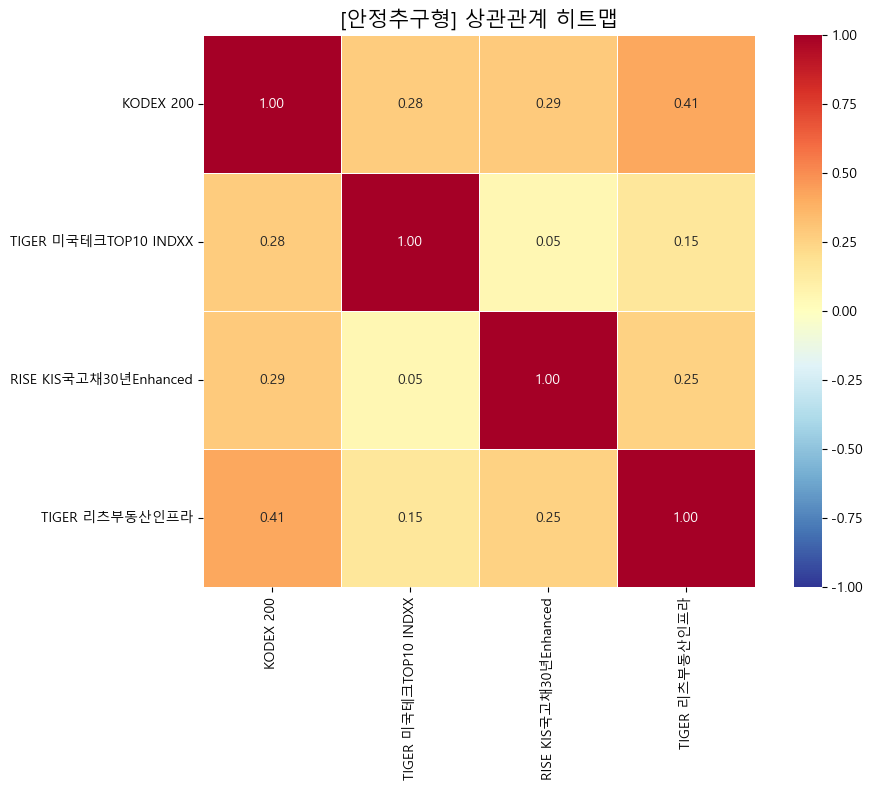


  -> [주성분 분석 결과]
    - 제1 주성분(PC1) 설명력: 43.89%
    - 제2 주성분(PC2) 설명력: 32.79%
    - 제3 주성분(PC3) 설명력: 16.80%
    - 누적 설명력: 93.49%
  -> [해석] 제1 주성분의 설명력이 60% 이하면 매우 우수한 분산 효과입니다. 이는 포트폴리오가 단일 팩터(시장)에 의존하지 않고 다양한 독립적 요인(금리, 환율 등)으로 구동됨을 의미합니다.

  -> [포트폴리오 성과 지표]
    - 연간 수익률: 23.75%
    - 연간 변동성: 10.62%
    - 샤프 비율: 2.237
  -> [해석] 안정추구형 전략은 낮은 변동성과 안정적인 샤프 비율을 목표로 합니다.


In [10]:
base_date = "20231228"
start_date_for_stats = "20230101"

print("\n" + "="*60); print("1. 안정추구형 유니버스 통계 검증"); print("="*60)

returns = build_universes.get_universe_returns(conservative_uni, start_date_for_stats, base_date)
display(returns.head())

# 검증 1: 상관관계 분석 (Correlation Analysis)
corr_matrix = returns.corr()

# 평균 상관계수 계산 (대각선 제외)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_triangle = corr_matrix.where(mask)
avg_corr = upper_triangle.stack().mean()

print(f"\n  -> [상관관계 통계]")
print(f"    - 평균 상관계수: {avg_corr:.3f}")
print(f"    - 최소 상관계수: {upper_triangle.stack().min():.3f}")
print(f"    - 최대 상관계수: {upper_triangle.stack().max():.3f}")
print(f"  -> [해석] 평균 상관계수가 0.3 이하면 우수한 분산 효과, 0.5 이하면 양호한 수준입니다.")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', fmt='.2f', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('[안정추구형] 상관관계 히트맵', fontsize=15)
plt.tight_layout()
plt.show()

# 검증 2: 주성분 분석 (Principal Component Analysis, PCA)
pca = PCA(n_components=min(3, len(returns.columns)))
pca.fit(returns)
explained_variance = pca.explained_variance_ratio_

print("\n  -> [주성분 분석 결과]")
for i, var in enumerate(explained_variance, 1):
    print(f"    - 제{i} 주성분(PC{i}) 설명력: {var:.2%}")
print(f"    - 누적 설명력: {explained_variance.sum():.2%}")
print("  -> [해석] 제1 주성분의 설명력이 60% 이하면 매우 우수한 분산 효과입니다. 이는 포트폴리오가 단일 팩터(시장)에 의존하지 않고 다양한 독립적 요인(금리, 환율 등)으로 구동됨을 의미합니다.")

# 검증 3: 포트폴리오 성과 지표
portfolio_returns = returns.mean(axis=1)  # 동일가중 포트폴리오
annual_return = portfolio_returns.mean() * 252
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else 0

print("\n  -> [포트폴리오 성과 지표]")
print(f"    - 연간 수익률: {annual_return:.2%}")
print(f"    - 연간 변동성: {annual_vol:.2%}")
print(f"    - 샤프 비율: {sharpe_ratio:.3f}")
print("  -> [해석] 안정추구형 전략은 낮은 변동성과 안정적인 샤프 비율을 목표로 합니다.")

# 공격 투자형 전략

## 투자 종목 선별

In [6]:
aggressive_uni_attack, aggressive_uni_safe = build_universes.build_aggressive_universe(etf_pool, "20231228")


2. 공격투자형 (듀얼 모멘텀) 유니버스 구성
  -> 과거 1년(20221228~20231228) 데이터로 변동성/베타 계산 중...


ETF 변동성/베타 계산: 100%|██████████| 163/163 [05:11<00:00,  1.91s/it]

--- 최종 선정 결과 ---

[공격 자산군]
    ticker           name asset_class  volatility      beta
43  232080   TIGER 코스닥150   국내주식(코스닥)    0.321154  1.556110
90  229200   KODEX 코스닥150   국내주식(코스닥)    0.320257  1.568710
53  139230  TIGER 200 중공업   국내주식(코스피)    0.266053  0.996704

[안전 자산]
    ticker                 name asset_class  volatility
63  423160  KODEX KOFR금리액티브(합성)       현금성자산    0.001288


## 통계적 검증


2. 공격투자형 유니버스 통계 검증

  -> [기술통계량 비교]
    - 공격군 종목 수: 3
    - 안전군 종목 수: 1
    - 공격군 평균 변동성: 30.26% (± 3.22%)
    - 안전군 평균 변동성: 0.13%
    - 변동성 차이: 30.14%

  ⚠️ [표본 크기 경고]
    현재: 공격군 3개, 안전군 1개
    권장: 각 그룹당 최소 5개 이상
    ⚠️ 통계적 검정 불가능 (최소 2개 필요)

  -> [기술통계량 비교]
    - 공격군 종목 수: 3
    - 안전군 종목 수: 1
    - 공격군 평균 변동성: 30.26% (± 3.22%)
    - 안전군 평균 변동성: 0.13%
    - 변동성 차이: 30.14%

  ⚠️ [표본 크기 경고]
    현재: 공격군 3개, 안전군 1개
    권장: 각 그룹당 최소 5개 이상
    ⚠️ 통계적 검정 불가능 (최소 2개 필요)


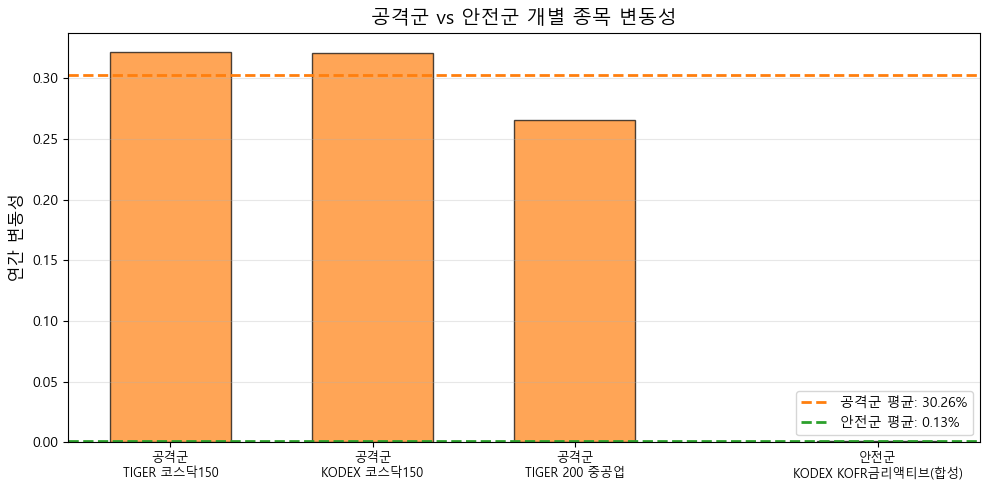

  -> [해석] 두 그룹의 변동성이 명확하게 분리될수록, 공격군과 안전군의 특성이 잘 구분됨을 의미합니다.

  [독립 표본 t-검정 (Welch's t-test)]

  ⚠️ [t-검정 불가]
    표본 크기가 부족합니다 (공격군: 3, 안전군: 1)
    t-검정에는 각 그룹당 최소 2개 이상의 관측치가 필요합니다.

  -> [대안: 단순 비교]
    - 공격군 평균 변동성: 30.26%
    - 안전군 평균 변동성: 0.13%
    - 절대 차이: 30.14%
    - 변동성 비율: 공격군이 안전군 대비 235.6배

  [종합 해석]

  📊 변동성 차이: 23456.0%
  📈 공격군 평균: 30.26%
  📉 안전군 평균: 0.13%

  ✓ 두 그룹의 변동성 차이가 매우 큽니다 (23456%).
  ✓ 공격군과 안전군이 명확하게 구분됩니다.

  💡 통계적 검정력 향상을 위해 더 많은 종목을 포함하는 것을 권장합니다.


In [15]:
base_date = "20231228"
start_date_for_stats = "20230101"

print("\n" + "="*60); print("2. 공격투자형 유니버스 통계 검증"); print("="*60)

attack_returns = build_universes.get_universe_returns(aggressive_uni_attack, start_date_for_stats, base_date)
safe_returns = build_universes.get_universe_returns(aggressive_uni_safe, start_date_for_stats, base_date)

# 각 종목별 연간 변동성 계산
attack_vols = attack_returns.std() * np.sqrt(252)
safe_vols = safe_returns.std() * np.sqrt(252)

# 검증 1: 기술통계량 비교
print("\n  -> [기술통계량 비교]")
print(f"    - 공격군 종목 수: {len(attack_vols)}")
print(f"    - 안전군 종목 수: {len(safe_vols)}")
print(f"    - 공격군 평균 변동성: {attack_vols.mean():.2%}" + 
      (f" (± {attack_vols.std():.2%})" if len(attack_vols) > 1 else ""))
print(f"    - 안전군 평균 변동성: {safe_vols.mean():.2%}" + 
      (f" (± {safe_vols.std():.2%})" if len(safe_vols) > 1 else ""))
print(f"    - 변동성 차이: {(attack_vols.mean() - safe_vols.mean()):.2%}")

# 표본 크기 경고
if len(attack_vols) < 5 or len(safe_vols) < 5:
    print(f"\n  ⚠️ [표본 크기 경고]")
    print(f"    현재: 공격군 {len(attack_vols)}개, 안전군 {len(safe_vols)}개")
    print(f"    권장: 각 그룹당 최소 5개 이상")
    if len(attack_vols) < 2 or len(safe_vols) < 2:
        print(f"    ⚠️ 통계적 검정 불가능 (최소 2개 필요)")
    else:
        print(f"    ⚠️ 통계적 검정력이 낮아 결과 해석에 주의 필요")

# 검증 2: 시각화
if len(attack_vols) > 1 and len(safe_vols) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 박스플롯
    vol_data = pd.concat([attack_vols.rename('공격군'), safe_vols.rename('안전군')], axis=1)
    sns.boxplot(data=vol_data, ax=axes[0], palette=['#ff7f0e', '#2ca02c'])
    axes[0].set_ylabel('연간 변동성', fontsize=12)
    axes[0].set_title('공격군 vs 안전군 변동성 분포', fontsize=14)
    axes[0].grid(axis='y', alpha=0.3)
    
    # 바이올린 플롯
    sns.violinplot(data=vol_data, ax=axes[1], palette=['#ff7f0e', '#2ca02c'])
    axes[1].set_ylabel('연간 변동성', fontsize=12)
    axes[1].set_title('변동성 분포 상세 (Violin Plot)', fontsize=14)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # 표본이 작을 경우 단순 막대 그래프
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x_pos = 0
    positions = []
    labels = []
    
    # 공격군 막대
    for i, (ticker, vol) in enumerate(attack_vols.items()):
        ax.bar(x_pos, vol, color='#ff7f0e', alpha=0.7, edgecolor='black', width=0.6)
        positions.append(x_pos)
        labels.append(f'공격군\n{ticker}')
        x_pos += 1
    
    # 간격
    x_pos += 0.5
    
    # 안전군 막대
    for i, (ticker, vol) in enumerate(safe_vols.items()):
        ax.bar(x_pos, vol, color='#2ca02c', alpha=0.7, edgecolor='black', width=0.6)
        positions.append(x_pos)
        labels.append(f'안전군\n{ticker}')
        x_pos += 1
    
    ax.set_ylabel('연간 변동성', fontsize=12)
    ax.set_title('공격군 vs 안전군 개별 종목 변동성', fontsize=14)
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # 평균선 추가
    ax.axhline(y=attack_vols.mean(), color='#ff7f0e', linestyle='--', 
               linewidth=2, label=f'공격군 평균: {attack_vols.mean():.2%}')
    ax.axhline(y=safe_vols.mean(), color='#2ca02c', linestyle='--', 
               linewidth=2, label=f'안전군 평균: {safe_vols.mean():.2%}')
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("  -> [해석] 두 그룹의 변동성이 명확하게 분리될수록, 공격군과 안전군의 특성이 잘 구분됨을 의미합니다.")

# 검증 3: 독립 표본 t-검정 (Welch's t-test)
print("\n" + "="*60)
print("  [독립 표본 t-검정 (Welch's t-test)]")
print("="*60)

# t-검정 수행 (최소 요구사항: 각 그룹 최소 2개)
if len(attack_vols) >= 2 and len(safe_vols) >= 2:
    # Welch's t-test 수행
    t_stat, p_value = ttest_ind(attack_vols, safe_vols, equal_var=False)
    
    # 자유도 계산 (Welch-Satterthwaite equation)
    n1, n2 = len(attack_vols), len(safe_vols)
    s1, s2 = attack_vols.std(), safe_vols.std()
    
    if s1 > 0 and s2 > 0:
        df = ((s1**2/n1 + s2**2/n2)**2) / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    else:
        df = n1 + n2 - 2
    
    print(f"\n  -> [검정 결과]")
    print(f"    - 검정 방법: Welch's t-test (등분산 가정 안함)")
    print(f"    - 귀무가설(H0): 공격군과 안전군의 평균 변동성이 같다")
    print(f"    - 대립가설(H1): 공격군과 안전군의 평균 변동성이 다르다")
    print(f"\n    - T-statistic: {t_stat:.4f}")
    print(f"    - P-value: {p_value:.6f}")
    print(f"    - 자유도(df): {df:.2f}")
    print(f"    - 표본 크기: n1={n1}, n2={n2}")
    
    # 통계적 유의성 판단
    alpha = 0.05
    print(f"\n  -> [통계적 유의성 (α = {alpha})]")
    
    if np.isnan(p_value):
        print(f"    ⚠️ P-value가 계산되지 않았습니다 (NaN)")
        print(f"    원인: 안전군의 표준편차가 0 (변동성 없음)")
        print(f"    해결: 더 많은 종목 추가 또는 기술통계량으로 판단")
    elif p_value < alpha:
        print(f"    ✓ P-value ({p_value:.6f}) < α ({alpha})")
        print(f"    → 귀무가설 기각: 두 집단의 평균 변동성은 통계적으로 유의미하게 다릅니다.")
        print(f"    → 공격군과 안전군이 성공적으로 분리되었습니다.")
    else:
        print(f"    ✗ P-value ({p_value:.6f}) >= α ({alpha})")
        print(f"    → 귀무가설 채택: 두 집단의 평균 변동성 차이가 통계적으로 유의미하지 않습니다.")
        print(f"    → 유니버스 구성을 재검토해야 합니다.")
    
    # 신뢰구간 계산
    from scipy import stats
    se_diff = np.sqrt(s1**2/n1 + s2**2/n2)
    mean_diff = attack_vols.mean() - safe_vols.mean()
    t_critical = stats.t.ppf(0.975, df)  # 95% 신뢰구간
    ci_lower = mean_diff - t_critical * se_diff
    ci_upper = mean_diff + t_critical * se_diff
    
    print(f"\n  -> [평균 차이의 95% 신뢰구간]")
    print(f"    - 평균 차이: {mean_diff:.2%}")
    print(f"    - 95% CI: [{ci_lower:.2%}, {ci_upper:.2%}]")
    if ci_lower > 0:
        print(f"    → 신뢰구간이 0을 포함하지 않음 → 공격군이 확실히 변동성이 높습니다.")
    
elif len(attack_vols) == 1 or len(safe_vols) == 1:
    print(f"\n  ⚠️ [t-검정 불가]")
    print(f"    표본 크기가 부족합니다 (공격군: {len(attack_vols)}, 안전군: {len(safe_vols)})")
    print(f"    t-검정에는 각 그룹당 최소 2개 이상의 관측치가 필요합니다.")
    print(f"\n  -> [대안: 단순 비교]")
    print(f"    - 공격군 평균 변동성: {attack_vols.mean():.2%}")
    print(f"    - 안전군 평균 변동성: {safe_vols.mean():.2%}")
    print(f"    - 절대 차이: {abs(attack_vols.mean() - safe_vols.mean()):.2%}")
    if safe_vols.mean() > 0:
        ratio = attack_vols.mean() / safe_vols.mean()
        print(f"    - 변동성 비율: 공격군이 안전군 대비 {ratio:.1f}배")

# 검증 4: 효과 크기 (Cohen's d)
if len(attack_vols) >= 2 and len(safe_vols) >= 2:
    print(f"\n" + "="*60)
    print("  [효과 크기 분석 (Cohen's d)]")
    print("="*60)
    
    # Pooled standard deviation 계산
    n1, n2 = len(attack_vols), len(safe_vols)
    s1, s2 = attack_vols.std(), safe_vols.std()
    
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    
    if pooled_std > 0 and not np.isnan(pooled_std):
        cohens_d = (attack_vols.mean() - safe_vols.mean()) / pooled_std
        
        print(f"\n  -> [Cohen's d 결과]")
        print(f"    - Cohen's d: {cohens_d:.3f}")
        
        # 효과 크기 해석 (Cohen's 기준)
        abs_d = abs(cohens_d)
        if abs_d < 0.2:
            effect = "매우 작음"
            interpretation = "실질적 차이가 거의 없음"
        elif abs_d < 0.5:
            effect = "작음"
            interpretation = "작은 실질적 차이"
        elif abs_d < 0.8:
            effect = "중간"
            interpretation = "중간 정도의 실질적 차이"
        else:
            effect = "큼"
            interpretation = "큰 실질적 차이"
        
        print(f"    - 효과 크기: {effect}")
        print(f"    - 해석: {interpretation}")
        print(f"\n  -> [Cohen's d 해석 기준]")
        print(f"    - |d| < 0.2: 매우 작음")
        print(f"    - 0.2 ≤ |d| < 0.5: 작음")
        print(f"    - 0.5 ≤ |d| < 0.8: 중간")
        print(f"    - |d| ≥ 0.8: 큼 (실질적으로 의미 있는 차이)")

# 종합 해석
print(f"\n" + "="*60)
print("  [종합 해석]")
print("="*60)

diff_pct = abs(attack_vols.mean() - safe_vols.mean()) / safe_vols.mean() * 100 if safe_vols.mean() > 0 else 0

print(f"\n  📊 변동성 차이: {diff_pct:.1f}%")
print(f"  📈 공격군 평균: {attack_vols.mean():.2%}")
print(f"  📉 안전군 평균: {safe_vols.mean():.2%}")

if diff_pct > 100:
    print(f"\n  ✓ 두 그룹의 변동성 차이가 매우 큽니다 ({diff_pct:.0f}%).")
    print(f"  ✓ 공격군과 안전군이 명확하게 구분됩니다.")
elif diff_pct > 50:
    print(f"\n  ✓ 두 그룹의 변동성 차이가 충분히 큽니다 ({diff_pct:.0f}%).")
    print(f"  ✓ 유니버스 구성이 적절합니다.")
else:
    print(f"\n  ⚠️ 두 그룹의 변동성 차이가 상대적으로 작습니다 ({diff_pct:.0f}%).")
    print(f"  → 더 뚜렷한 구분을 위해 선정 기준을 조정하는 것을 권장합니다.")

if len(attack_vols) < 5 or len(safe_vols) < 5:
    print(f"\n  💡 통계적 검정력 향상을 위해 더 많은 종목을 포함하는 것을 권장합니다.")

# 위험 중립형 전략

## 투자 종목 선별

In [8]:
neutral_uni = build_universes.build_neutral_universe(etf_pool)


3. 위험중립형 (멀티팩터) 유니버스 구성
--- 최종 선정 결과 (계층적 분류 엔진 기준) ---
        factor                    name
476  국내주식(코스피)               KODEX 200
25        국내채권  RISE KIS국고채30년Enhanced
197       대체자산          TIGER 리츠부동산인프라
217  해외주식(기술주)   TIGER 미국테크TOP10 INDXX


## 통계적 검증


3. 위험중립형 유니버스 통계 검증

  -> [상관관계 통계]
    - 평균 상관계수: 0.240
    - 최소 상관계수: 0.054
    - 최대 상관계수: 0.415
  -> [해석] 위험중립형은 다양한 자산군(주식/채권/대체자산)을 포함하여 평균 상관계수가 0.4 이하면 우수합니다.

  -> [계층적 군집 분석]

  -> [상관관계 통계]
    - 평균 상관계수: 0.240
    - 최소 상관계수: 0.054
    - 최대 상관계수: 0.415
  -> [해석] 위험중립형은 다양한 자산군(주식/채권/대체자산)을 포함하여 평균 상관계수가 0.4 이하면 우수합니다.

  -> [계층적 군집 분석]


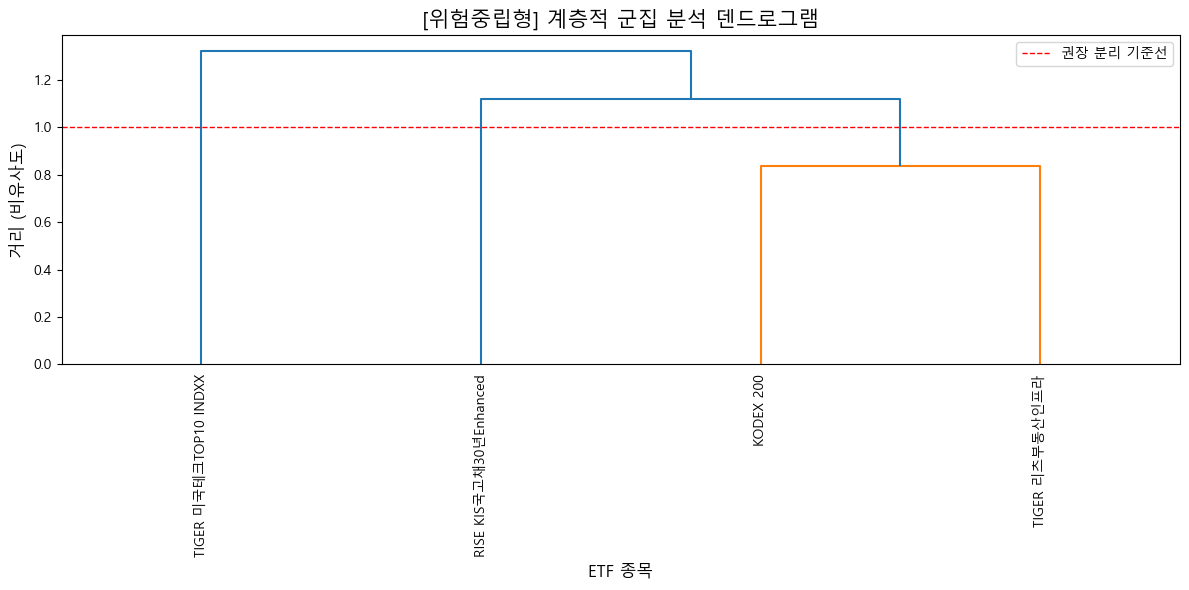

  -> [해석] 덴드로그램의 가지들이 서로 멀리 떨어져 있고, 명확한 군집(예: 주식군 vs 채권군 vs 대체자산군)을 형성할수록 다양성이 높습니다.

  -> [개별 자산 성과 지표]


,연간수익률,연간변동성,샤프비율
TIGER 미국테크TOP10 INDXX,0.649,0.197,3.290
KODEX 200,0.226,0.157,1.434
RISE KIS국고채30년Enhanced,0.154,0.197,0.780
TIGER 리츠부동산인프라,-0.078,0.099,-0.788



  -> [포트폴리오 성과 지표 (동일가중)]
    - 연간 수익률: 23.75%
    - 연간 변동성: 10.62%
    - 샤프 비율: 2.237
    - 종목 수: 4

  -> [분산 효과 분석]
    - 개별 자산 평균 변동성: 16.27%
    - 포트폴리오 변동성: 10.62%
    - 변동성 감소율: 34.75%
  -> [해석] 변동성 감소율이 20% 이상이면 우수한 분산 효과를 보이고 있습니다.


In [13]:
base_date = "20231228"
start_date_for_stats = "20230101"

print("\n" + "="*60); print("3. 위험중립형 유니버스 통계 검증"); print("="*60)

returns = build_universes.get_universe_returns(neutral_uni, start_date_for_stats, base_date)

# 검증 1: 상관관계 분석
corr_matrix = returns.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_triangle = corr_matrix.where(mask)
avg_corr = upper_triangle.stack().mean()

print(f"\n  -> [상관관계 통계]")
print(f"    - 평균 상관계수: {avg_corr:.3f}")
print(f"    - 최소 상관계수: {upper_triangle.stack().min():.3f}")
print(f"    - 최대 상관계수: {upper_triangle.stack().max():.3f}")
print(f"  -> [해석] 위험중립형은 다양한 자산군(주식/채권/대체자산)을 포함하여 평균 상관계수가 0.4 이하면 우수합니다.")

# 검증 2: 계층적 군집 분석 (Hierarchical Clustering)
print("\n  -> [계층적 군집 분석]")
linkage_matrix = linkage(1 - corr_matrix, method='ward')  # 1-상관관계 = 거리

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=returns.columns, leaf_rotation=90, leaf_font_size=10)
plt.title('[위험중립형] 계층적 군집 분석 덴드로그램', fontsize=15)
plt.ylabel('거리 (비유사도)', fontsize=12)
plt.xlabel('ETF 종목', fontsize=12)
plt.axhline(y=1.0, color='r', linestyle='--', linewidth=1, label='권장 분리 기준선')
plt.legend()
plt.tight_layout()
plt.show()
print("  -> [해석] 덴드로그램의 가지들이 서로 멀리 떨어져 있고, 명확한 군집(예: 주식군 vs 채권군 vs 대체자산군)을 형성할수록 다양성이 높습니다.")

# 검증 3: 각 자산의 특성 분석
annual_returns = returns.mean() * 252
annual_vols = returns.std() * np.sqrt(252)
sharpe_ratios = annual_returns / annual_vols

asset_stats = pd.DataFrame({
    '연간수익률': annual_returns,
    '연간변동성': annual_vols,
    '샤프비율': sharpe_ratios
}).round(3)

print("\n  -> [개별 자산 성과 지표]")
display(asset_stats.sort_values('샤프비율', ascending=False))

# 검증 4: 포트폴리오 수준 분석
portfolio_returns = returns.mean(axis=1)
port_annual_return = portfolio_returns.mean() * 252
port_annual_vol = portfolio_returns.std() * np.sqrt(252)
port_sharpe = port_annual_return / port_annual_vol if port_annual_vol != 0 else 0

print(f"\n  -> [포트폴리오 성과 지표 (동일가중)]")
print(f"    - 연간 수익률: {port_annual_return:.2%}")
print(f"    - 연간 변동성: {port_annual_vol:.2%}")
print(f"    - 샤프 비율: {port_sharpe:.3f}")
print(f"    - 종목 수: {len(returns.columns)}")

# 개별 자산 평균과 비교
avg_individual_vol = annual_vols.mean()
diversification_benefit = (avg_individual_vol - port_annual_vol) / avg_individual_vol

print(f"\n  -> [분산 효과 분석]")
print(f"    - 개별 자산 평균 변동성: {avg_individual_vol:.2%}")
print(f"    - 포트폴리오 변동성: {port_annual_vol:.2%}")
print(f"    - 변동성 감소율: {diversification_benefit:.2%}")
print("  -> [해석] 변동성 감소율이 20% 이상이면 우수한 분산 효과를 보이고 있습니다.")